In [9]:
from os import getenv
from dotenv import load_dotenv
from hub_downloader import Downloader
from hub_visualizer import Visualizer

%reload_ext autoreload
%autoreload 1
%aimport hub_downloader
%aimport hub_visualizer

load_dotenv();

In [54]:
owner = 'pandas-dev'
repo = 'pandas'

github_token = getenv('GITHUB_OAUTH_TOKEN')
downloader = Downloader(owner, repo, github_token, verbose=True)
#downloader.delete_cache()

The maximum number of requests you are permitted to make per hour: 5000
The number of requests remaining in the current rate limit window: 4947


In [55]:
commit_activity = downloader.get_commit_activity()
commit_activity

,week_unix_ts,mon,tue,wed,thu,fri,sat,sun,week
0,1558828800,2,4,5,6,1,15,4,2019-05-26
1,1559433600,7,2,11,5,10,9,4,2019-06-02
2,1560038400,10,8,11,4,9,0,8,2019-06-09
3,1560643200,2,6,5,8,13,2,5,2019-06-16
4,1561248000,0,7,8,17,23,7,2,2019-06-23
5,1561852800,10,8,22,3,5,5,9,2019-06-30
6,1562457600,8,10,10,7,12,0,5,2019-07-07
7,1563062400,11,3,10,6,1,7,0,2019-07-14
8,1563667200,7,12,9,16,8,1,1,2019-07-21
9,1564272000,2,3,10,7,7,1,1,2019-07-28


In [56]:
total_contributions, weekly_contributions = downloader.get_contributors_statistic()

In [57]:
total_contributions

,user,commits
0,xhochy,10
1,Bharat123rox,10
2,proost,11
3,funnycrab,11
4,dhimmel,11
...,...,...
95,TomAugspurger,665
96,jorisvandenbossche,697
97,jbrockmendel,1866
98,jreback,2758


In [58]:
weekly_contributions

,user,week_unix_ts,date,additions,deletions,commits
0,xhochy,1249171200,2009-08-02,0,0,0
1,xhochy,1249776000,2009-08-09,0,0,0
2,xhochy,1250380800,2009-08-16,0,0,0
3,xhochy,1250985600,2009-08-23,0,0,0
4,xhochy,1251590400,2009-08-30,0,0,0
...,...,...,...,...,...,...
56395,wesm,1587254400,2020-04-19,0,0,0
56396,wesm,1587859200,2020-04-26,0,0,0
56397,wesm,1588464000,2020-05-03,0,0,0
56398,wesm,1589068800,2020-05-10,0,0,0


In [59]:
stargazers = downloader.get_stargazers()
stargazers

Fetching stargazers ............................................................................................................................................................................................................................................................


,user,starred_at
0,sbusso,2010-08-24
1,auser,2010-08-24
2,pfig,2010-08-24
3,ludwig,2010-08-24
4,bryanveloso,2010-08-24
...,...,...
24972,gutzbenj,2020-05-19
24973,hsbt,2020-05-19
24974,manpp,2020-05-19
24975,Badboy-16,2020-05-19


In [60]:
issues = downloader.get_issues()
issues

Fetching repository issues ......................................


,id,state,created_at
0,621098694,open,2020-05-19
1,621095664,open,2020-05-19
2,621076809,open,2020-05-19
3,621071148,open,2020-05-19
4,621022573,open,2020-05-19
...,...,...,...
3539,5787008,open,2012-07-23
3540,4863349,open,2012-06-01
3541,4647887,open,2012-05-18
3542,4485088,open,2012-05-09


In [61]:
code_frequency = downloader.get_code_frequency_statistic()
code_frequency

,week_unix_ts,additions,deletions,date
0,1249171200,21659,-4,2009-08-02
1,1249776000,0,0,2009-08-09
2,1250380800,0,0,2009-08-16
3,1250985600,0,0,2009-08-23
4,1251590400,1707,-819,2009-08-30
...,...,...,...,...
559,1587254400,3917,-2775,2020-04-19
560,1587859200,6274,-4252,2020-04-26
561,1588464000,3412,-2405,2020-05-03
562,1589068800,7253,-5247,2020-05-10


In [62]:
pandas_visualizer = Visualizer(owner, repo)

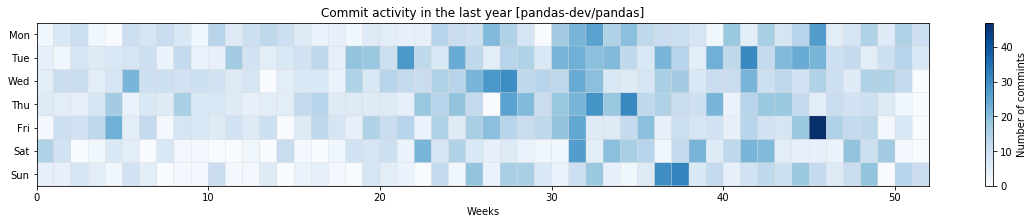

In [63]:
pandas_visualizer.commit_activity()

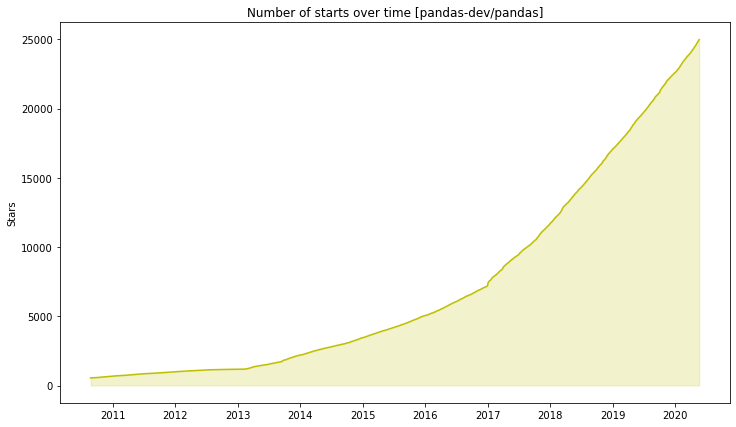

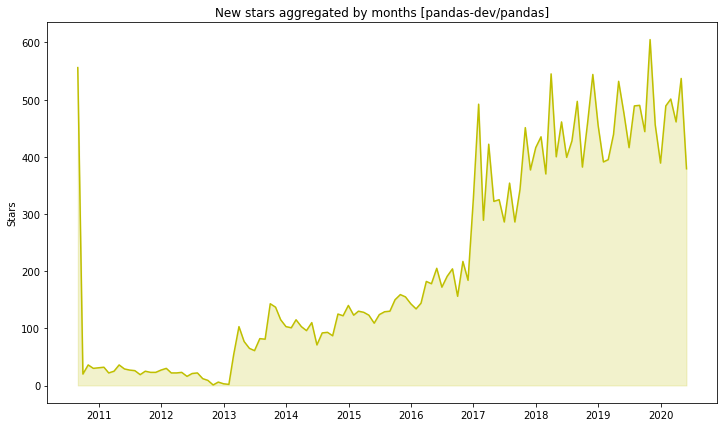

In [64]:
pandas_visualizer.stargazer_history()

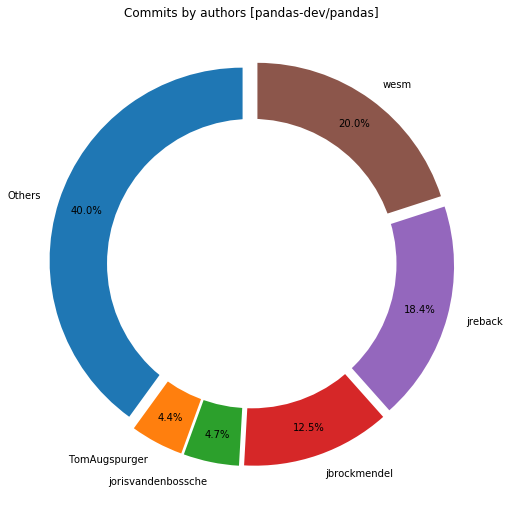

In [65]:
pandas_visualizer.commits_by_author(limit=5)

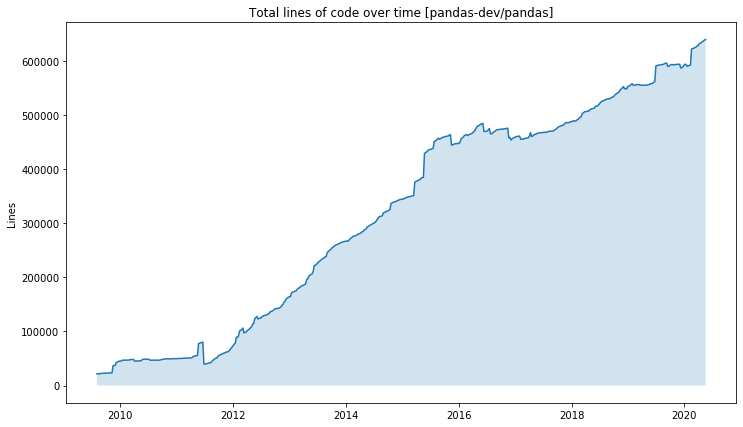

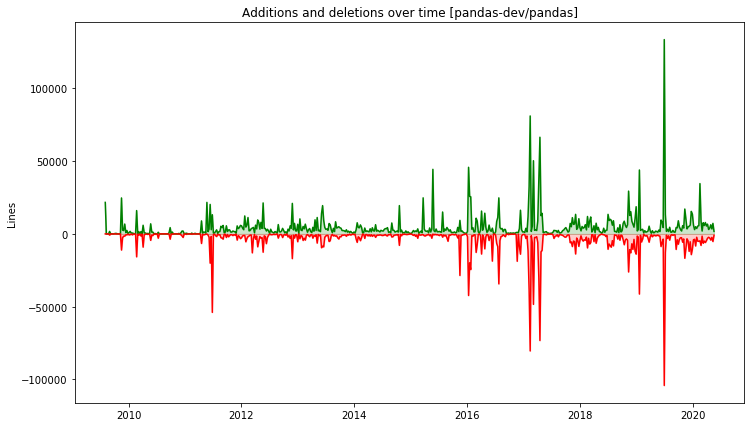

In [66]:
pandas_visualizer.lines_over_time()